In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact

import pandas as pd
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import arviz as az

Populating the interactive namespace from numpy and matplotlib


# Question 1

During your internship at EPCOR, you are given a dataset containing 10,000 observations of monthly utility bills (in Canadian dollars) for Edmonton houses over the last couple of years. Along with the monthly bill, you are also given:

- `avg_temperature`: the average temperature during the billing month (in Celsius).
- `household_size`: the number of people living in the house during the billing month.
- `house_taxes`: the yearly property taxes according to the last tax notice (in Canadian dollars).

Under the consent of residents, the City of Edmonton kindly provided household and taxes information for the dataset. This information was matched, but it's not perfect.

Your goal is to determine whether the utility bill amount can be predicted using the other three variables.

## A (15 points)

Load the data from the file `EPCOR1.csv` (link provided below) into a Pandas DataFrame. Clean the data by removing any corrupted values.

Do you think using mean imputation is a better approach to deal with corrupted observations in this case? Explain.

In [2]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/Epcor1.csv'
data = pd.read_csv(path_to_data)
display(data.head(2))

,avg_temperature,household_size,house_taxes,bill
0,21.083807,4,2341.40,339.825365
1,17.945661,2,4061.82,317.335924


In [3]:
display(data.describe())

,avg_temperature,household_size,house_taxes,bill
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.261718,2.098500,4107.637598,310.312478
std,8.226165,1.175388,6314.119179,13.754624
min,-25.774117,0.000000,682.060000,287.571982
25%,-1.410821,1.000000,2718.060000,300.194427
50%,4.249438,2.000000,3613.900000,307.332263
75%,9.875206,3.000000,4519.920000,317.376281
max,38.480774,8.000000,99999.000000,446.639790


In [4]:
# too high bills ($99,999)
# empty household (or at least acknowledge)
print((data['house_taxes'] == 99999).value_counts())
print((data['household_size'] == 0).value_counts())

house_taxes
False    9959
True       41
Name: count, dtype: int64
household_size
False    9469
True      531
Name: count, dtype: int64


In [5]:
data['house_taxes'] = data['house_taxes'].replace(to_replace=99999, value=np.nan)
data['household_size'] = data['household_size'].replace(to_replace=0, value=np.nan)
data.dropna(inplace=True)
display(data.describe())

,avg_temperature,household_size,house_taxes,bill
count,9431.000000,9431.000000,9431.000000,9431.000000
mean,4.254857,2.215884,3711.537761,310.370274
std,8.215385,1.095080,1425.767380,13.810276
min,-25.774117,1.000000,682.060000,287.571982
25%,-1.378533,1.000000,2707.880000,300.209999
50%,4.230073,2.000000,3603.720000,307.407366
75%,9.878262,3.000000,4499.560000,317.422401
max,38.480774,8.000000,13641.200000,446.639790


### Answer

Either dropping or imputation or removal is ok. If removing values significantly decreases the dataset size, then imputation makes sense in favour of more data. If corrupted values exists several columns in the same row, dropping makes sense in light of data issues. At the end it deppends on: why are the values corrupted? what does corrupted mean for the business question? and, how is the model going to be used?

## B (10 points)

Create scatter plots for the utility bill versus the average temperature and the property taxes in different subplots within the same figure.

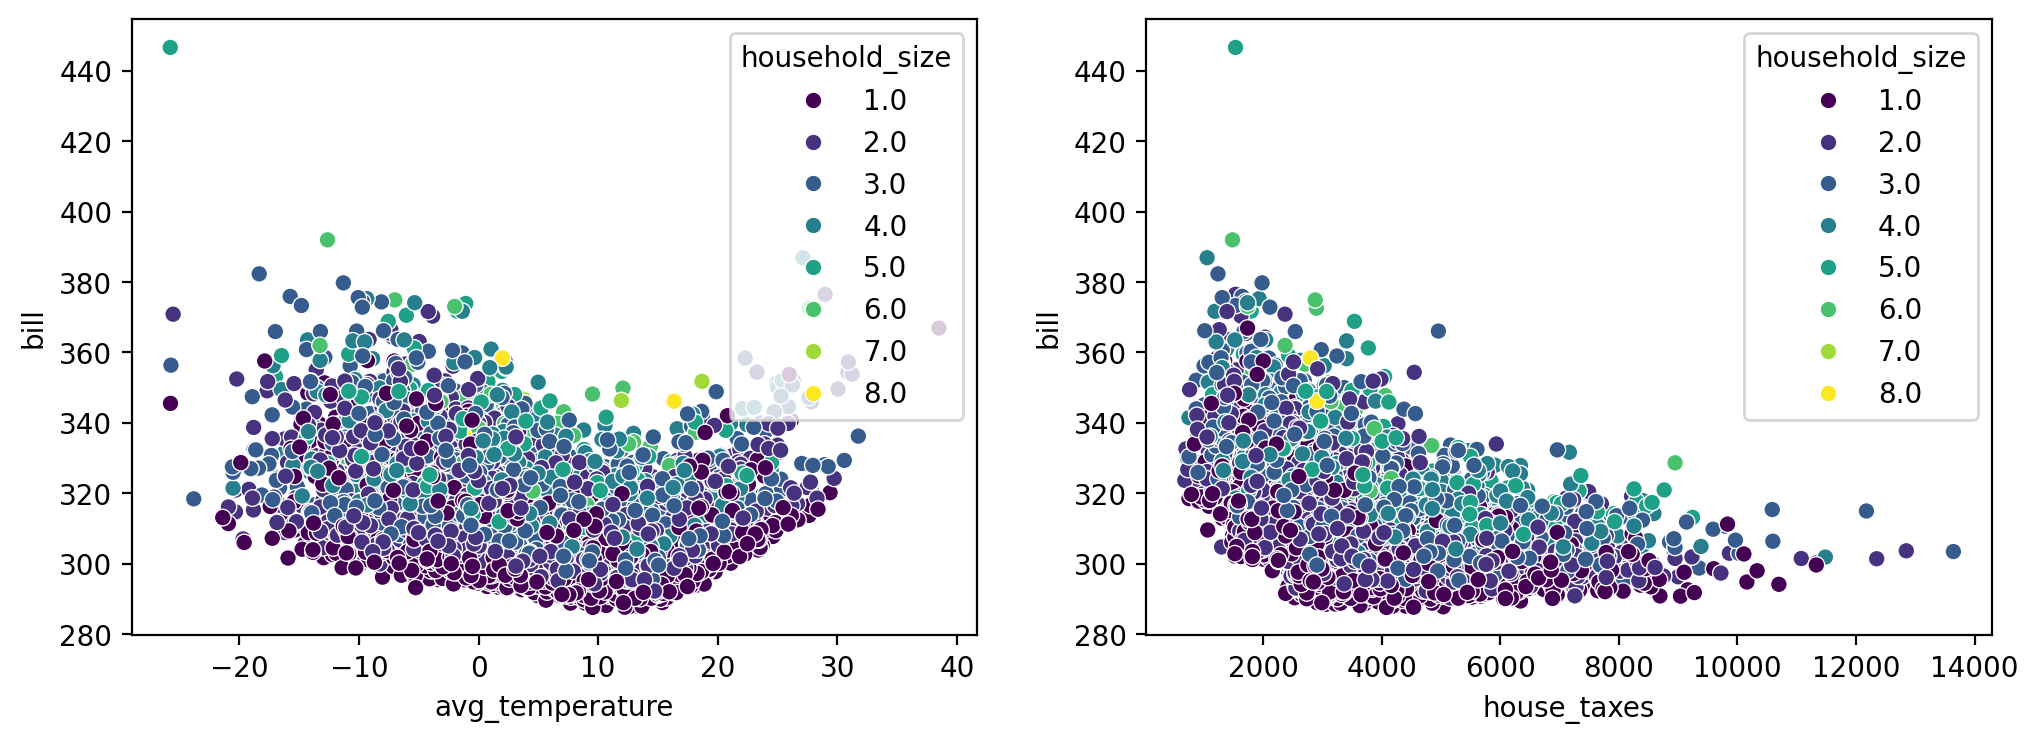

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.scatterplot(data, x='avg_temperature', y='bill', hue='household_size', palette='viridis', legend='full')
plt.subplot(122)
sns.scatterplot(data, x='house_taxes', y='bill', hue='household_size', palette='viridis', legend='full');

## C (10 points)

Preprocess the data by standardizing all predictor variables.

In [7]:
from sklearn.preprocessing import StandardScaler
cols_to_standardize = ['avg_temperature', 'household_size', 'house_taxes']
scaler = StandardScaler()
data[cols_to_standardize] = scaler.fit_transform(data[cols_to_standardize])
display(data.describe())

,avg_temperature,household_size,house_taxes,bill
count,9.431000e+03,9.431000e+03,9.431000e+03,9431.000000
mean,4.068424e-17,-6.818377e-17,-4.339652e-16,310.370274
std,1.000053e+00,1.000053e+00,1.000053e+00,13.810276
min,-3.655406e+00,-1.110374e+00,-2.124918e+00,287.571982
25%,-6.857485e-01,-1.110374e+00,-7.039795e-01,300.209999
50%,-3.016933e-03,-1.971502e-01,-7.562487e-02,307.407366
75%,6.845332e-01,7.160734e-01,5.527297e-01,317.422401
max,4.166297e+00,5.282191e+00,6.964803e+00,446.639790


## D (25 points)

Propose prior distributions for a simple linear model for `bill` using `avg_temperature` and `household_size` as predictors. Create prior predictive plots. Use MCMC sampling (make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 20 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distributions.

### Answer

Linear model D

\begin{align*}
    B_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + \beta_T \cdot T + \beta_N \cdot N \\
    \alpha & \sim \text{Normal}(300, 10) \\
    \beta_T & \sim \text{Normal}(0, 1) \\
    \beta_N & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Exponential}(\tfrac{1}{10})
\end{align*}

Priors:

* $\alpha$: mean around \$300
* $\beta_i$: standardized predictor
* $\sigma$: error accounting for \$10 in avg.

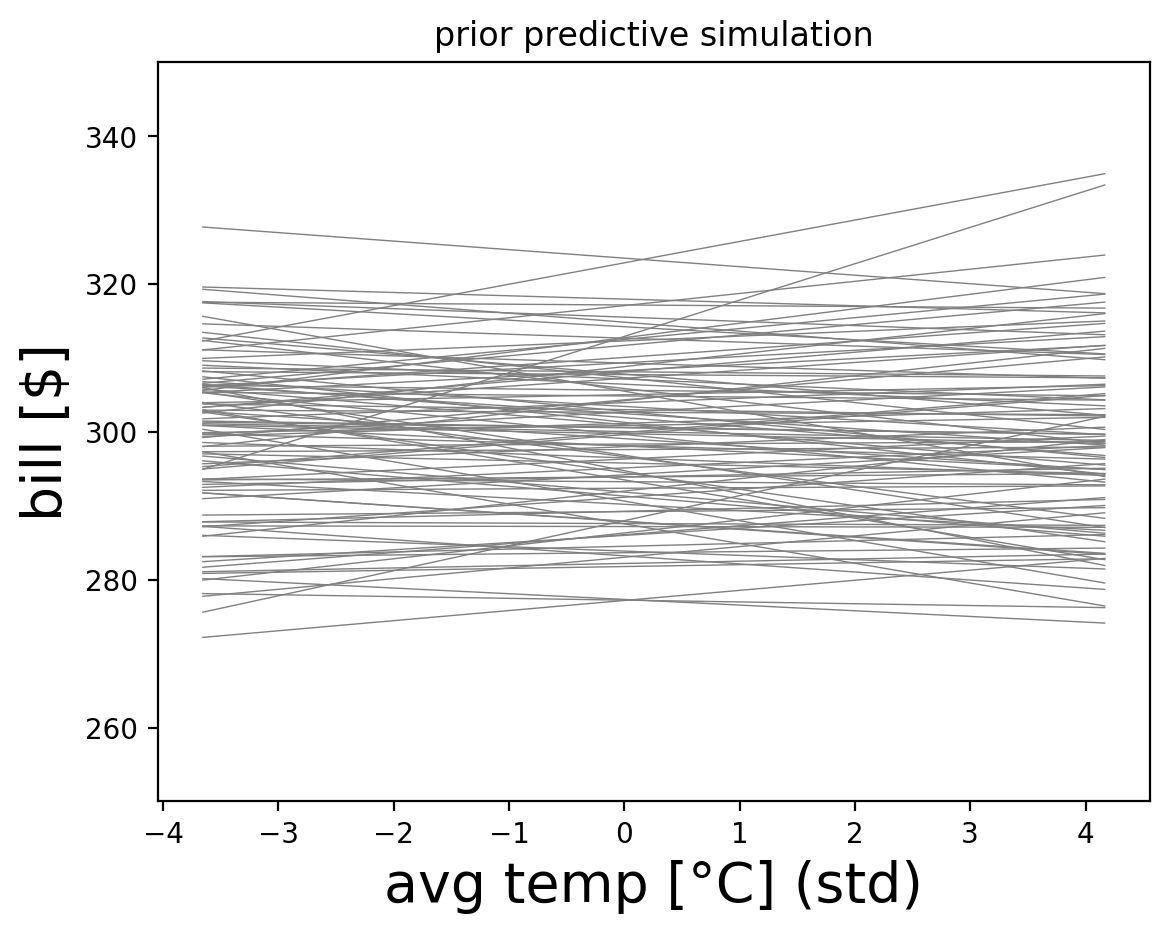

In [8]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(300, 10, n_samples)
beta_T = stats.norm.rvs(0, 1, n_samples)
beta_N = stats.norm.rvs(0, 1, n_samples)
_x = data['avg_temperature']
x1 = np.linspace(_x.min(), _x.max(), 5) ## weight range
_x = data['household_size']
x2 = np.linspace(_x.min(), _x.max(), 5) ## weight range
b_avg = alpha[None, :] + beta_T*(x1[:, None]) + beta_N*(x2[:, None]) ## we are using broadcasting here
plt.plot(x1, b_avg, '0.5', lw=0.5)
plt.ylim(250, 350)
plt.title('prior predictive simulation')
plt.xlabel('avg temp [°C] (std)', fontsize=20)
plt.ylabel('bill [$]', fontsize=20);

In [9]:
with pm.Model() as model_1:
    sigma = pm.Exponential('sigma', 1/10)
    beta_T = pm.Normal('beta_temp', mu=0, sigma=1)
    beta_N = pm.Normal('beta_size', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=300, sigma=10)
    mu = alpha + beta_T*data['avg_temperature'] + beta_N*data['household_size']
    B = pm.Normal('bill', mu=mu, sigma=sigma, observed=data['bill'])
    ## MCMC
    m1_posterior = pm.sample(1000, tune=1000, chains=4)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,310.369,0.123,310.120,310.591,0.002,0.001,5617.0,2956.0,1.0
beta_temp,-4.499,0.123,-4.720,-4.273,0.002,0.001,6605.0,3323.0,1.0
beta_size,5.471,0.123,5.256,5.720,0.002,0.001,6569.0,3274.0,1.0
sigma,11.771,0.086,11.614,11.931,0.001,0.001,6360.0,3356.0,1.0


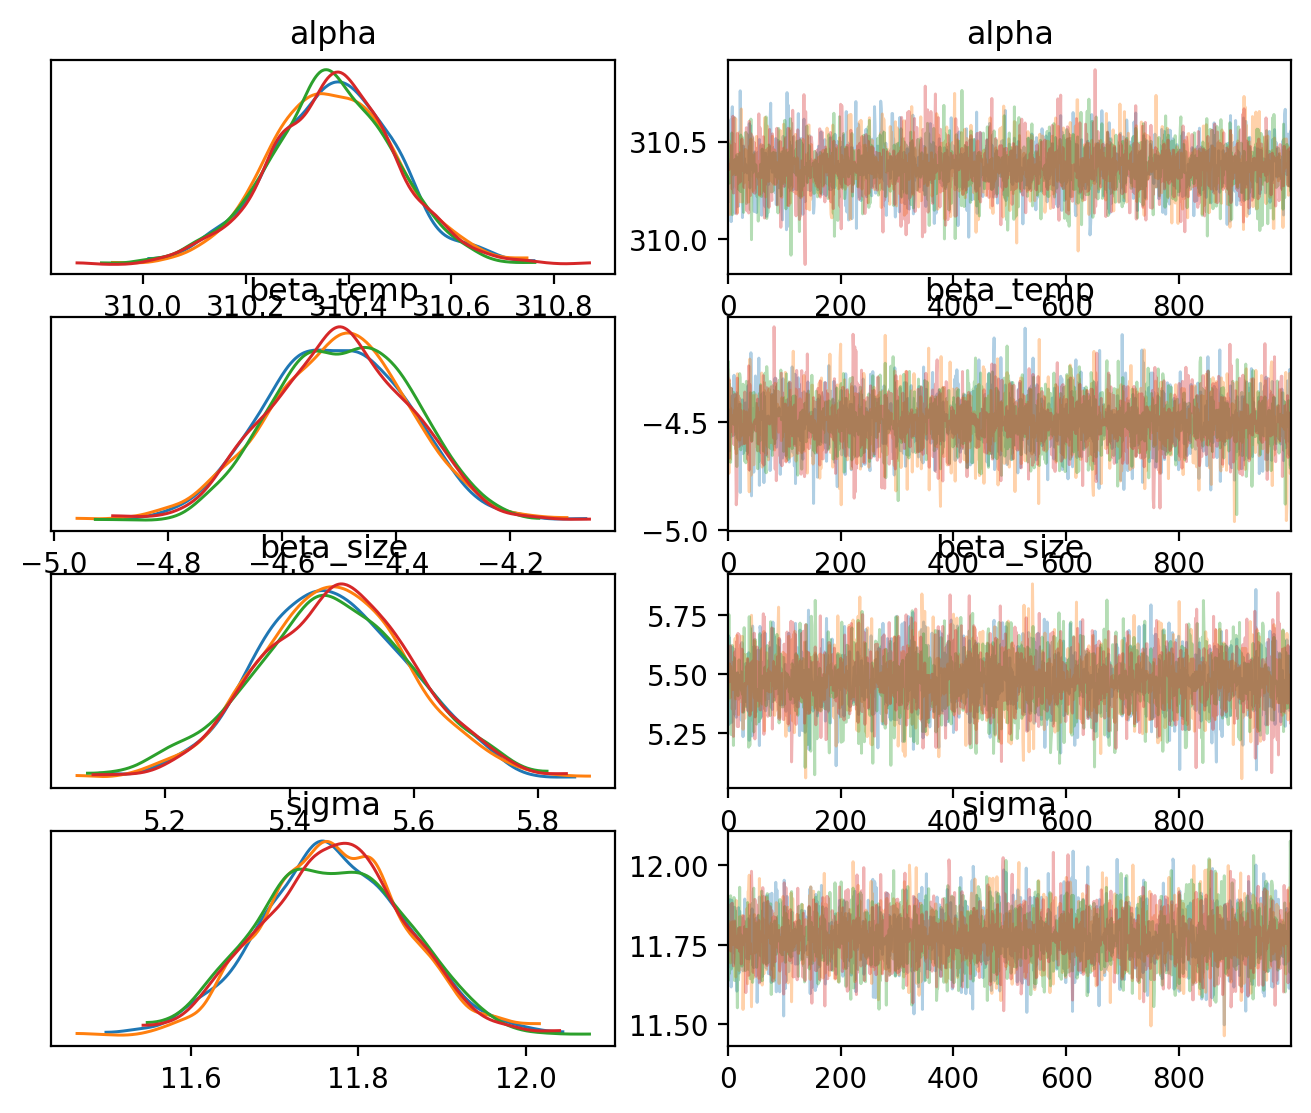

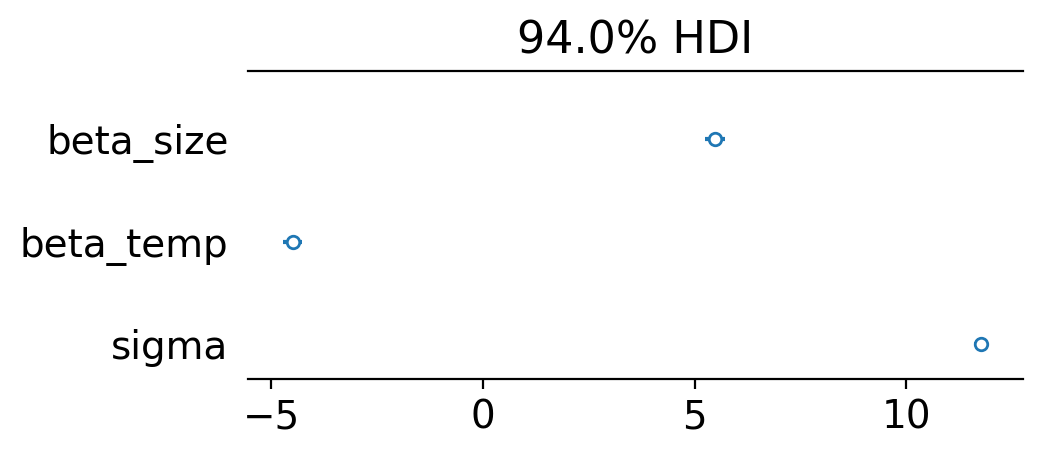

In [10]:
varnames = ['alpha', 'beta_temp', 'beta_size', 'sigma']
display(pm.summary(m1_posterior, var_names=varnames))
az.plot_trace(m1_posterior, varnames, compact=False, figsize=(8, 1.6*len(varnames)))
az.plot_forest(m1_posterior, var_names=['~alpha'], combined=True, figsize=[5, 2]);

## E (10 points)

Based on the scatter plot obtained in part B, do you think this is a reasonable model? Interpret the mean of the posterior for each of the parameters. Comment on the relationship between the monthly average temperature and the utility bill amount. How would you approach modeling the utility bill as a function of the average monthly temperature?

### Answer

Not a very reasonable model. Plot shows non-linear relationship between average temprature and bill.

The coefficient for temperature is negative, but the plot shows negative slope for colder days and positive slope for negative slope for hotter days, which makes sense in terms of furnace and AC usage.

The coefficient for household size is positive, and this is consistent with expectation of more poeple more usage.

A quadratic term on temperature, or seasonal modelling, or gas/electricity/water split would make more sense.

## F (20 points)

Extend the linear model by adding `house_taxes` as a predictor. Use MCMC sampling (again, make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 25 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distribution.

### Answer

Linear model F

\begin{align*}
    B_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + \beta_T \cdot T + \beta_N \cdot N + \beta_X \cdot X\\
    \alpha & \sim \text{Normal}(300, 10) \\
    \beta_T & \sim \text{Normal}(0, 1) \\
    \beta_N & \sim \text{Normal}(0, 1) \\
    \beta_X & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Exponential}(\tfrac{1}{10})
\end{align*}

Priors:

* $\alpha$: mean around \$300
* $\beta_i$: standardized predictor
* $\sigma$: error accounting for \$10 in avg.

In [11]:
with pm.Model() as model_2:
    sigma = pm.Exponential('sigma', 1/10)
    beta_T = pm.Normal('beta_temp', mu=0, sigma=1)
    beta_N = pm.Normal('beta_size', mu=0, sigma=1)
    beta_X = pm.Normal('beta_tax', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=300, sigma=10)
    mu = alpha + beta_T*data['avg_temperature'] + beta_N*data['household_size'] + beta_X*data['house_taxes']
    B = pm.Normal('bill', mu=mu, sigma=sigma, observed=data['bill'])
    ## MCMC
    m2_posterior = pm.sample(1000, tune=1000, chains=4)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,310.368,0.103,310.177,310.567,0.001,0.001,5850.0,3301.0,1.0
beta_temp,-4.472,0.100,-4.660,-4.288,0.001,0.001,7316.0,3109.0,1.0
beta_size,5.608,0.102,5.423,5.806,0.001,0.001,7143.0,3089.0,1.0
beta_tax,-6.370,0.100,-6.551,-6.183,0.001,0.001,5655.0,3076.0,1.0
sigma,9.857,0.071,9.730,9.993,0.001,0.001,7355.0,3216.0,1.0


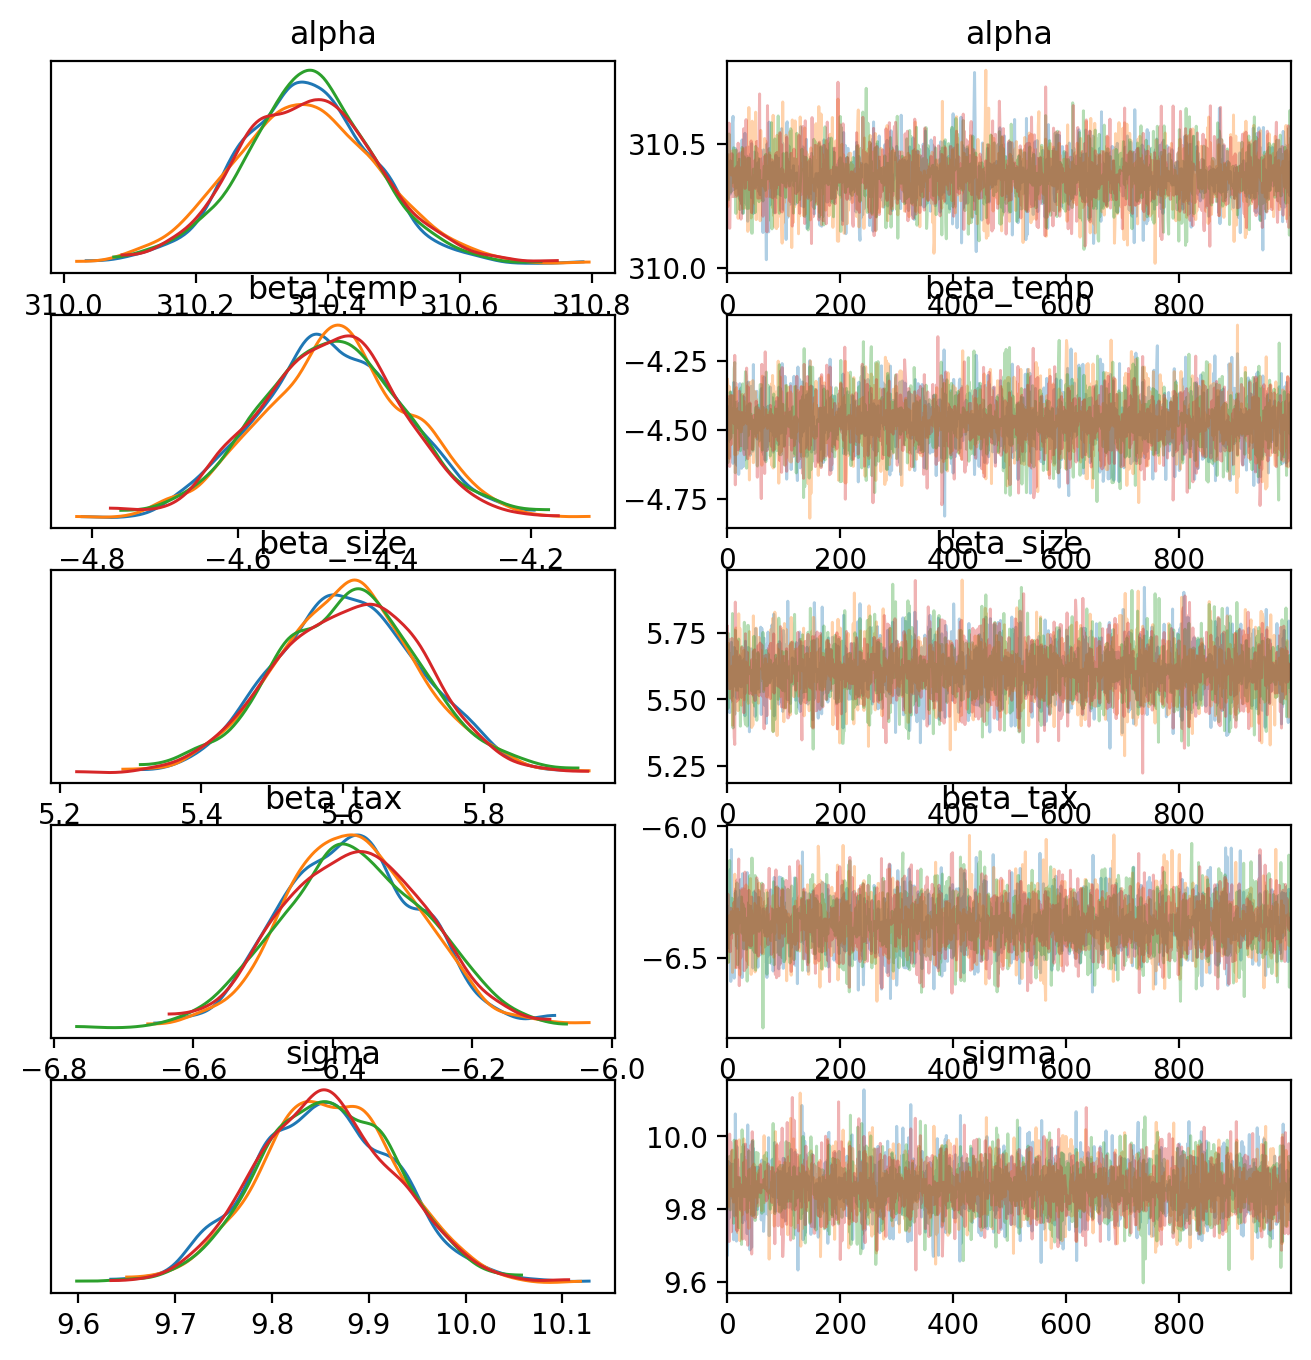

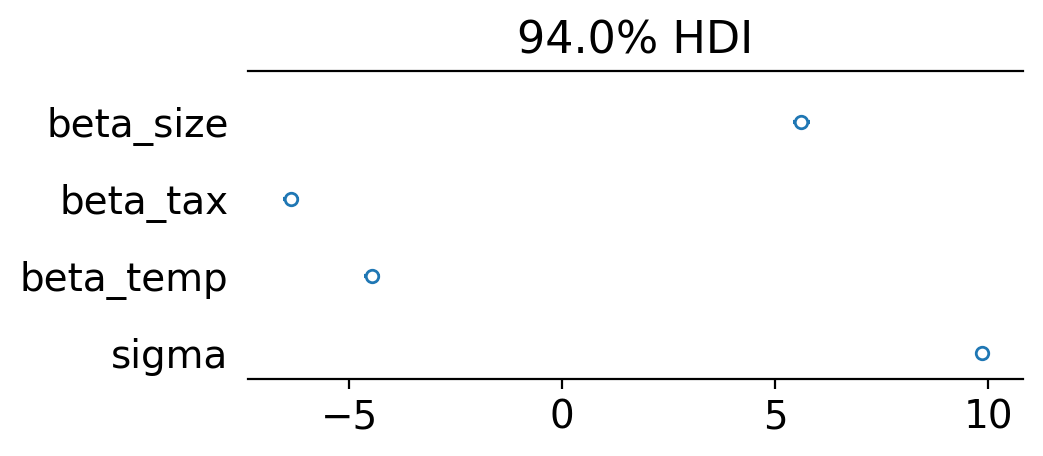

In [12]:
varnames = ['alpha', 'beta_temp', 'beta_size', 'beta_tax', 'sigma']
display(pm.summary(m2_posterior, var_names=varnames))
az.plot_trace(m2_posterior, varnames, compact=False, figsize=(8, 1.6*len(varnames)))
az.plot_forest(m2_posterior, var_names=['~alpha'], combined=True, figsize=[5, 2]);

## G (10 points)

Interpret the mean of the posterior for the new parameter. Compare the other mean posterior values with those obtained in part E. Based on the scatter plot you obtained in part B, do you think this is a reasonable model? Comment on the relationship between the yearly property taxes and the utility bill amount. What do you think is happening here?

### Answer

The parameter for tax is negative, meaning higher taxes means lower utility bills. Moreover, it has a similar magnitude, and even a larger absolute value, than the other coefficients.

The other parameters remain similar compared to the previous model, meaning the other predictors are not conditioned on taxes. The uncertainty decreased slightly.

The model is still not reasonable, and even less so with taxes, because "higher taxes, lower utility bills" is counterintuitive (people living in more expensive houses would tend to spend more on everything, including utilities).

Several things could be happening, but two things are certain about property taxes:
 * They are yearly and,
 * They are calculated only based on the market value of the property.

Even if taxes can be used as a predictor, it's unlikely to have a causal effect on the utility bill. That is, taxes and the bill are most likely confounded variables and the relationship we see is probably spurious. More analysis is needed.

Although energy efficiency, solar panels, retrofits, and government programs are possible and good explanations, they assume that property taxes is a good predictor for utility bills.

In [14]:
print("Carlos Contreras")

Carlos Contreras


Carlos Contreras